Multi-level Perturbed Unit Gradient Descent, MPUGD

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data  import Subset, DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.models  as models
from types import SimpleNamespace 
import matplotlib.pyplot  as plt
import numpy as np 

from optimizers import *
from upanets import UPANets
from torchsummary import summary
import time, copy,timm
import json
import random 
import os
from train import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
args = SimpleNamespace(
    datasets='cifar_100',
    batch_size = 500,
    seed = 42,
    lr=0.1, 
    momentum=0.9,
    wd = 0.0005,
    blocks = 1,
    filters = 16,
    epochs = 400,
    start_epochs = 8
    )

In [3]:
def set_all_seeds(seed=42):
    # Python原生随机 
    random.seed(seed) 
    # NumPy随机 
    np.random.seed(seed) 
    # PyTorch随机 
    torch.manual_seed(seed) 
    # CUDA随机（GPU相关）
    torch.cuda.manual_seed_all(seed) 
    # CUDNN确定性模式 
    torch.backends.cudnn.deterministic  = True 
    torch.backends.cudnn.benchmark  = False 
 
set_all_seeds(args.seed)  

In [4]:
print(device)

cuda


In [5]:
img_size = 32 # default image size for Cifar-10
im_dimention = 32
cifar_10_mean = [0.4914, 0.4822, 0.4465] 
cifar_10_std = [0.2023, 0.1994, 0.2010]
cifar_100_mean = [0.5071, 0.4867, 0.4408]
cifar_100_std = [0.2673, 0.2564, 0.2762]

if args.datasets == 'cifar_10':
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.RandomRotation(15,),
            transforms.RandomCrop(im_dimention),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
            # transforms.Lambda(lambda x: x.to(torch.float16))    # 最终输出FP16
        ]),
        # 'valid': transforms.Compose([
        #     transforms.Resize((im_dimention,im_dimention)),
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        # ]),
        'test': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        ]),
    }
 
    full_trainset = torchvision.datasets.CIFAR10(
        root='./data/cifar_10', train=True, download=True, transform=data_transforms['train'])
    testset = torchvision.datasets.CIFAR10(
        root='./data/cifar_10', train=False, download=True, transform=data_transforms['test'])
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=args.batch_size, shuffle=False, num_workers=0)
    Num_class = 10

if args.datasets == 'cifar_100':
    data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(im_dimention),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    # 'valid': transforms.Compose([
    #     transforms.Resize((im_dimention,im_dimention)),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    # ]),
    'test': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    }
    full_trainset = torchvision.datasets.CIFAR100(
        root='./data/cifar_100', train=True, download=True, transform=data_transforms['train'])
    testset = torchvision.datasets.CIFAR100(
        root='./data/cifar_100', train=False, download=True, transform=data_transforms['test'])
    testloader = DataLoader(
        testset, batch_size=args.batch_size, shuffle=False,sampler=torch.utils.data.SequentialSampler(testset),  num_workers=0)
    Num_class = 100

# # 获取所有样本的标签 
# labels = [full_trainset[i][1] for i in range(len(full_trainset))]

# # 分层划分（stratify参数确保比例）
# train_idx, val_idx = train_test_split(
#     range(len(full_trainset)),
#     test_size=0.2,
#     shuffle=True,
#     stratify=labels,
#     random_state=args.seed  
# )

# train_data = np.stack([full_trainset.data[i]  for i in train_idx]) 
# train_targets = [full_trainset.targets[i] for i in train_idx] 
# val_data = np.stack([full_trainset.data[i]  for i in val_idx]) 
# val_targets = [full_trainset.targets[i] for i in val_idx] 

# valset = full_trainset
# valset.data = val_data
# valset.targets = val_targets
# valset.transform = data_transforms['valid']

# trainset = copy.deepcopy(valset)
# trainset.data = train_data
# trainset.targets = train_targets
# trainset.transform = data_transforms['train']

# trainloader = {
#     'train':DataLoader(
#     trainset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(trainset), num_workers=0),
#     'valid':DataLoader(
#     valset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(valset), num_workers=0)}

# dataset_sizes = {
#     'train': len(trainset),
#     'valid': len(valset),            
                #  }

trainloader = {
    'train':DataLoader(
    full_trainset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(full_trainset), num_workers=0),
    'valid':testloader
}

dataset_sizes = {
    'train': len(full_trainset),
    'valid': len(testset),      
}
print(dataset_sizes)


{'train': 50000, 'valid': 10000}


In [6]:
print(timm.list_models('*vit_tiny_patch16_224*')) 

['vit_tiny_patch16_224']


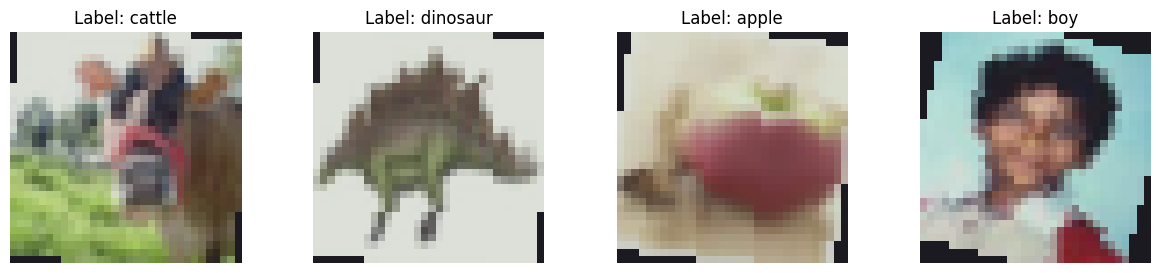

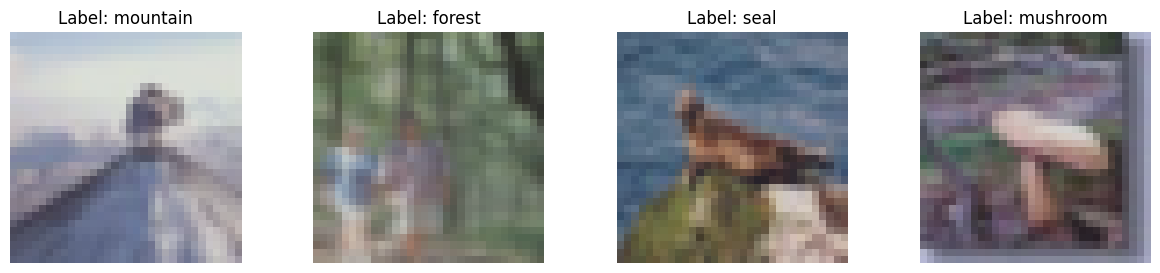

In [7]:
# from torchvision.transforms.functional  import to_pil_image 
# 反归一化转换（需与transform中的参数对应）
inv_normalize = transforms.Normalize(
    mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
    std=[1/0.2023, 1/0.1994, 1/0.2010]
)
 
def show_images(loader, num_images=4):
    # 获取一个batch的数据 
    # images, labels = next(iter(loader))
    for batch_idx, (images, labels) in enumerate(loader):
        if batch_idx == 0:  # 只取第一个batch 
            break 

    # 创建子图 
    fig, axes = plt.subplots(1,  num_images, figsize=(15, 3))
    
    for i in range(num_images):
        # 反归一化+通道顺序调整 
        img = inv_normalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img,  0, 1)  # 处理浮点误差 
        
        # 显示图像及标签 
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {full_trainset.classes[labels[i]]}") 
        axes[i].axis('off')
    
    plt.show() 
 
show_images(trainloader['train'])
show_images(testloader)

In [8]:
model_path = "./model/" + args.datasets + "/benchmark.pth"
if os.path.exists(model_path):
    net_benckmark_data = torch.load(model_path,  map_location='cpu')
    benckmark_state_dict = net_benckmark_data['model_state_dict'] 
else:
    net_benchmark = UPANets(args.filters, Num_class, args.blocks, img_size)
    torch.save({
        'model_state_dict': net_benchmark.state_dict()
    }, model_path)
    benckmark_state_dict = net_benchmark.state_dict()

def tensor_to_serializable(obj):
    if isinstance(obj, (np.float32,  np.float64)):   # 处理NumPy浮点数
        return float(obj)
    elif isinstance(obj, np.integer):               # 处理NumPy整数 
        return int(obj)
    elif isinstance(obj, torch.Tensor):            # 处理PyTorch Tensor 
        return obj.item()  if obj.numel()  == 1 else obj.tolist() 
    elif isinstance(obj, (np.ndarray)):             # 处理NumPy数组 
        return obj.tolist() 
    elif hasattr(obj, '__dict__'):                 # 处理自定义对象（可选）
        return obj.__dict__
    return obj 


In [9]:
# net_pugdt_delta = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdt_delta.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdt_delta.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdt_delta = torch.nn.DataParallel(net_pugdt_delta)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXT(net_pugdt_delta.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdt_delta, metricst_delta = train_model_timing_delta(net_pugdt_delta, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes, int(args.epochs/10), 0.01, 10) 

# model_path = "./model/"+args.datasets+"/pugdt_delta_" + str(args.epochs) + "xi" + str(args.epochs/10) + "mu0.01_t10.pth"
# torch.save({
#     'model_state_dict': net_pugdt_delta.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdt_delta_" + str(args.epochs) + "xi" + str(args.epochs/10) + "mu0.01_t10.json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricst_delta,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [10]:
# net_pugdt_var = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdt_var.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdt_var.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdt_var = torch.nn.DataParallel(net_pugdt_var)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXT(net_pugdt_var.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdt_var, metricst_var = train_model_timing_var(net_pugdt_var, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes, int(args.epochs/10), 0.015, 10) 

# model_path = "./model/"+args.datasets+"/pugdt_var_" + str(args.epochs) + "init_t" + str(args.epochs/10) + "gamma0.015_k10.pth"
# torch.save({
#     'model_state_dict': net_pugdt_var.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdt_var_" + str(args.epochs) + "init_t" + str(args.epochs/10) + "gamma0.015_k10.json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricst_var,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [11]:
# net = UPANets(args.filters, Num_class, args.blocks, img_size)
# net.load_state_dict(copy.deepcopy(benckmark_state_dict))

# criterion = torch.nn.CrossEntropyLoss()

# net.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True

# optimizer = optim.SGD(net.parameters(),
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net, metrics_org = train_model_org(net, criterion, optimizer, scheduler, args.epochs * 2, trainloader, device, dataset_sizes) 

# # 保存模型架构+参数+优化器状态（完整恢复训练）
# model_path = "./model/"+args.datasets+"/org" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/org_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metrics_org, f, default=tensor_to_serializable, ensure_ascii=False, indent=4)
 
# # 加载 

# # checkpoint = torch.load('full_model_checkpoint.pth',  map_location='cpu')  # 先加载到CPU避免设备冲突 
# # 模型结构需提前定义（需与保存时一致）
# # model = YourModelClass()  
# # model.load_state_dict(checkpoint['model_state_dict']) 
 
# # # 恢复优化器和训练状态 
# # optimizer = torch.optim.Adam(model.parameters())  
# # optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 
# # with open('data.json',  'r', encoding='utf-8') as f:
# #     loaded_dict = json.load(f) 


# # summary(net, (3, img_size, img_size))


In [12]:
# net_pugdr_sin = UPANets(args.filters, Num_class, args.blocks, img_size)
# net_pugdr_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdr_sin.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugdr_sin)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(net_pugdr_sin.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.2, 
#                 max_beta = 2.0, 
#                 method = 'sin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugdr_sin, metricsr_sin = train_model_alpha(net_pugdr_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdr_sin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdr_sin.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdr_sin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [13]:
# net_pugdr_cos = UPANets(args.filters, Num_class, args.blocks, img_size)
# net_pugdr_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdr_cos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugdr_cos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(net_pugdr_cos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.001, 
#                 max_beta = 2.0, 
#                 method = 'cos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugdr_cos, metricsr_sin = train_model_alpha(net_pugdr_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdr_cos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdr_cos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdr_cos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [14]:
# for i in range(5):
#     if metricsr_sin['bast_acc'] < 0.7234:
#         net_pugdr_cos = UPANets(args.filters, Num_class, args.blocks, img_size)
#         net_pugdr_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
#         criterion = torch.nn.CrossEntropyLoss()

#         net_pugdr_cos.to(device)

#         if device == 'cuda' and torch.cuda.device_count() > 1:
#             model_ft_org = torch.nn.DataParallel(net_pugdr_cos)
#             cudnn.benchmark = True

#         base_optimizer = optim.SGD
#         optimizer = PUGDXR(net_pugdr_cos.parameters(),
#                         base_optimizer,
#                         lr=args.lr,
#                         max_epochs= args.epochs,
#                         momentum=args.momentum,
#                         weight_decay=args.wd,
#                         min_beta = 0.0, 
#                         max_beta = 2.0, 
#                         method = 'cos',
#                         dampening=0,   # 必须设置为0才能完全固定 
#                         nesterov=False # 禁用Nesterov动量 
#                         )

#         scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
#         # Decay LR by a factor of 0.1 every 7 epochs
#         # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#         net_pugdr_cos, metricsr_sin = train_model_alpha(net_pugdr_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

#         model_path = "./model/"+args.datasets+"/pugdr_cos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
#         torch.save({
#             'model_state_dict': net_pugdr_cos.state_dict(), 
#             'optimizer_state_dict': optimizer.state_dict()
#         }, model_path) 

#         name = "./results/"+args.datasets+"/pugdr_cos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
#         with open(name,  'w', encoding='utf-8') as f:
#             json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [15]:
# net_pugdr_cos = UPANets(args.filters, Num_class, args.blocks, img_size)
# net_pugdr_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdr_cos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugdr_cos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(net_pugdr_cos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.0, 
#                 max_beta = 3.0, 
#                 method = 'cos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugdr_cos, metricsr_sin = train_model_alpha(net_pugdr_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdr_cos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdr_cos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdr_cos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [16]:
# net_pugds_cos = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_cos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_cos = torch.nn.DataParallel(net_pugds_cos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_cos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 1.2, 
#                 max_beta = 3.0,
#                 method = 'cos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugds_cos, metricss_cos = train_model_alpha(net_pugds_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_cos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_cos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_cos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_cos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [17]:
# net_pugds_sin = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_sin.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_sin = torch.nn.DataParallel(net_pugds_sin)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_sin.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 1.8, 
#                 max_beta = 2.0,
#                 method = 'sin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugds_sin, metricss_sin = train_model_alpha(net_pugds_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_sin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_sin.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_sin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [18]:
# net_pugd = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugd.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugd.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugd)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDX(net_pugd.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugd, metrics0 = train_model(net_pugd, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugd" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugd.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugd_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [19]:
# net_pugdr_cos = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdr_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdr_cos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugdr_cos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(net_pugdr_cos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.3, 
#                 max_beta = 1, 
#                 method = 'icos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdr_cos, metricsr_cos = train_model_alpha(net_pugdr_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdr_icos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdr_cos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdr_icos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsr_cos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [20]:
# net_pugdr_sin = UPANets(args.filters, Num_class, args.blocks, img_size)
# net_pugdr_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdr_sin.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(net_pugdr_sin)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(net_pugdr_sin.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.1, 
#                 max_beta = 1, 
#                 method = 'isin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugdr_sin, metricsr_sin = train_model_alpha(net_pugdr_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdr_isin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdr_sin.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdr_isin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [21]:
# net_pugds_icos = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_icos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_icos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_icos = torch.nn.DataParallel(net_pugds_icos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_icos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.01, 
#                 max_beta = 0.5, 
#                 method = 'icos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugds_icos, metricss_icos = train_model_alpha(net_pugds_icos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_icos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_icos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_icos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_icos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [22]:
# net_pugds_icos = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_icos.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_icos.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_icos = torch.nn.DataParallel(net_pugds_icos)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_icos.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.05, 
#                 max_beta = 1.0, 
#                 method = 'icos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugds_icos, metricss_icos = train_model_alpha(net_pugds_icos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_icos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_icos.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_icos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_icos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [23]:
# net_pugds_isin = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugds_isin.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugds_isin.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugds_isin = torch.nn.DataParallel(net_pugds_isin)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXS(net_pugds_isin.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.1, 
#                 max_beta = 2,
#                 method = 'isin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# net_pugds_isin, metricss_isin = train_model_alpha(net_pugds_isin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugds_isin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugds_isin.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugds_isin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricss_isin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [24]:
# net_pugdrs = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdrs.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdrs.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdrs = torch.nn.DataParallel(net_pugdrs)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXRS(net_pugdrs.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta_r = 0.01, 
#                 max_beta_r = 2, 
#                 method_r = 'isin',
#                 min_beta_s = 0, 
#                 max_beta_s = 1.5,
#                 method_s = 'cos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdrs, metricsrs = train_model_alpha(net_pugdrs, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdrs_" + str(optimizer.method_r) + str(optimizer.max_beta_r) + "_" + str(optimizer.min_beta_r) + "_" + str(optimizer.method_s) + str(optimizer.max_beta_s) + "_" + str(optimizer.min_beta_s) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdrs.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdrs_" + str(optimizer.method_r) + str(optimizer.max_beta_r) + "_" + str(optimizer.min_beta_r) + "_" + str(optimizer.method_s) + str(optimizer.max_beta_s) + "_" + str(optimizer.min_beta_s) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsrs,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [25]:
# net_pugdrs = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdrs.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdrs.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdrs = torch.nn.DataParallel(net_pugdrs)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXRS(net_pugdrs.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 max_epochs= args.epochs,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta_r = 0.0,
#                 max_beta_r = 2.0,
#                 method_r = 'sin',
#                 min_beta_s = 0.0, 
#                 max_beta_s = 2.0,
#                 method_s = 'sin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdrs, metricsrs = train_model_alpha(net_pugdrs, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/"+args.datasets+"/pugdrs_" + str(optimizer.method_r) + str(optimizer.max_beta_r) + "_" + str(optimizer.min_beta_r) + "_" + str(optimizer.method_s) + str(optimizer.max_beta_s) + "_" + str(optimizer.min_beta_s) + "_" + str(args.epochs) + ".pth"
# torch.save({
#     'model_state_dict': net_pugdrs.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdrs_" + str(optimizer.method_r) + str(optimizer.max_beta_r) + "_" + str(optimizer.min_beta_r) + "_" + str(optimizer.method_s) + str(optimizer.max_beta_s) + "_" + str(optimizer.min_beta_s) + "_" + str(args.epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricsrs,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [26]:
# VGG-16 ResNet-18 DenseNet-121* growth rate in 16 UPANet-16 Overall Average

In [27]:
# ## finetune

# from transformers import ViTForImageClassification, DeiTForImageClassification 
 
# # 加载预训练模型 
# vit_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=10, ignore_mismatched_sizes=True, device_map="auto", resume_download=True) 
# deit_model = DeiTForImageClassification.from_pretrained("facebook/deit-base-patch16-224", num_labels=10, ignore_mismatched_sizes=True, device_map="auto", resume_download=True) 



In [28]:
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
#     optimizer,  # 绑定的优化器对象 
#     mode='max',  # 监测指标模式 
#     factor=0.5,  # 学习率衰减系数 
#     patience=3   # 等待周期数 
# )
# for name, param in vit_model.named_parameters(): 
#     if 'encoder.layer.0'  in name:  # 冻结前N层 
#         param.requires_grad  = False 
# # 修改分类头以适应CIFAR-10的10类 
# vit_model.classifier  = torch.nn.Linear(vit_model.config.hidden_size,  10)
# deit_model.classifier  = torch.nn.Linear(deit_model.config.hidden_size,  10)

In [29]:
# print(new_head.__dict__)
# print(vars(new_head))
# import optimizers
# import importlib 
# importlib.reload(optimizers)   
# from optimizers import *

In [30]:
# model_ft2 = timm.create_model('mobilenetv3_small_100', pretrained=True, num_classes=Num_class)
# original_head = model_ft2.classifier   # MobileNetV3的分类头名为classifier 
# new_head = nn.Linear(original_head.in_features,  Num_class)
# model_ft2 = model_ft2.to(device)
# criterion = torch.nn.CrossEntropyLoss()


# base_optimizer2 = optim.SGD
# optimizer2 = PUGD2(model_ft2.parameters(),
#                  base_optimizer2,
#                  lr=args.lr,
#                  momentum=args.momentum,
#                  weight_decay=args.wd,
#                  )


# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1)

# model_ft2 = train_model2(model_ft2, criterion, optimizer2, exp_lr_scheduler, num_epochs=20) 

In [31]:
# ft_epochs = 300
# os.environ.update({ 
#     "HF_ENDPOINT": "https://hf-mirror.com", 
#     "HF_HUB_OFFLINE": "0",  # 确保非离线模式 
#     "HF_HUB_DISABLE_TELEMETRY": "1",  # 禁用检测请求 
#     "HF_CDN_DOMAIN": "hf-mirror.com", 
#     "HF_S3_ENDPOINT": "hf-mirror.com", 
#     "TRANSFORMERS_OFFLINE": "0",       # transformers专用设置 
#     "HF_DATASETS_OFFLINE": "0"         # datasets专用设置 
# })

In [32]:
# import requests 
# endpoints = ["https://hf-mirror.com",  "https://huggingface.co"] 
# for url in endpoints:
#     try:
#         r = requests.get(f"{url}/api/models",  timeout=5)
#         print(f"{url} 响应状态: {r.status_code}") 
#     except Exception as e:
#         print(f"{url} 连接失败: {type(e).__name__}")

In [33]:
# ft_epochs = 300
# 加载预训练ResNet18
resnet18 = models.resnet18(weights=("pretrained", models.ResNet18_Weights.IMAGENET1K_V1))

# 冻结所有卷积层
# for name, param in resnet18.named_parameters(): 
#     if 'fc' not in name:  # 排除最后的全连接层
#         param.requires_grad  = False

resnet18.fc  = torch.nn.Linear(resnet18.fc.in_features,  Num_class)

e:\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
# ft_epochs = 200
# resnet18_copy1 = copy.deepcopy(resnet18)
# criterion = torch.nn.CrossEntropyLoss()

# resnet18_copy1.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(resnet18_copy1)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDX(resnet18_copy1.parameters(),
#                 base_optimizer,
#                 lr=0.01,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ft_epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# resnet18_copy1, metrics0 = train_model(resnet18_copy1, criterion, optimizer, scheduler, ft_epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/lfs/"+args.datasets+"/resnet18_pugd" + str(ft_epochs) + ".pth"
# torch.save({
#     'model_state_dict': resnet18_copy1.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/resnet18_pugd_" + str(ft_epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [112]:
ft_epochs = 200
resnet18_copy1 = copy.deepcopy(resnet18)
criterion = torch.nn.CrossEntropyLoss()

resnet18_copy1.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(resnet18_copy1)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXR(resnet18_copy1.parameters(),
                base_optimizer,
                lr=0.01,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 8.0, 
                max_beta = 10,
                method = 'sin',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ft_epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

resnet18_copy1, metrics0 = train_model(resnet18_copy1, criterion, optimizer, scheduler, ft_epochs, trainloader, device, dataset_sizes) 

model_path = "./model/lfs/"+args.datasets+"/resnet18_pugdr_" + str(optimizer.method) + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(ft_epochs) + ".pth"
torch.save({
    'model_state_dict': resnet18_copy1.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/resnet18_pugdr_" + str(optimizer.method) + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" +  str(ft_epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/199
7.9486987590789795
Epoch 1/199
7.718895673751831
Epoch 2/199
7.610345363616943
Epoch 3/199
7.641237497329712
Epoch 4/199
7.762565612792969
Epoch 5/199
7.585090637207031
Epoch 6/199
7.547120094299316
Epoch 7/199
7.5596230030059814
Epoch 8/199
7.580765247344971
Epoch 9/199
7.517432928085327
Epoch 10/199
7.677819490432739
Epoch 11/199
7.545671224594116
Epoch 12/199
7.477651596069336
Epoch 13/199
7.516470670700073
Epoch 14/199
7.668240070343018
Epoch 15/199
7.642920017242432
Epoch 16/199
7.567986249923706
Epoch 17/199
7.747403621673584
Epoch 18/199
7.5731425285339355
Epoch 19/199
7.626915454864502
Epoch 20/199
7.711003303527832
Epoch 21/199
7.617855787277222
Epoch 22/199
7.660419225692749
Epoch 23/199
7.707245588302612
Epoch 24/199
7.6093223094940186
Epoch 25/199
7.852248191833496
Epoch 26/199
7.664438009262085
Epoch 27/199
7.582745552062988
Epoch 28/199
7.60415244102478
Epoch 29/199
7.571258306503296
Epoch 30/199
7.720505237579346
Epoch 31/199
7.6521315574646
Epoch 32/199
7.65

In [114]:
ft_epochs = 200
resnet18_copy1 = copy.deepcopy(resnet18)
criterion = torch.nn.CrossEntropyLoss()

resnet18_copy1.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(resnet18_copy1)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXR(resnet18_copy1.parameters(),
                base_optimizer,
                lr=0.01,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 3.0, 
                max_beta = 10,
                method = 'sin',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ft_epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

resnet18_copy1, metrics0 = train_model(resnet18_copy1, criterion, optimizer, scheduler, ft_epochs, trainloader, device, dataset_sizes) 

model_path = "./model/lfs/"+args.datasets+"/resnet18_pugdr_" + str(optimizer.method) + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(ft_epochs) + ".pth"
torch.save({
    'model_state_dict': resnet18_copy1.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/resnet18_pugdr_" + str(optimizer.method) + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" +  str(ft_epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/199
8.548946857452393
Epoch 1/199
8.308665037155151
Epoch 2/199
8.276022911071777
Epoch 3/199
8.233057737350464
Epoch 4/199
8.509968996047974
Epoch 5/199
8.235347986221313
Epoch 6/199
8.270201444625854
Epoch 7/199
8.270421266555786
Epoch 8/199
8.259424686431885
Epoch 9/199
8.337769031524658
Epoch 10/199
8.267012119293213
Epoch 11/199
8.49018931388855
Epoch 12/199
8.328078031539917
Epoch 13/199
8.297568321228027
Epoch 14/199
8.33276104927063
Epoch 15/199
8.28247880935669
Epoch 16/199
8.250569820404053
Epoch 17/199
8.367702007293701
Epoch 18/199
8.340120792388916
Epoch 19/199
8.352041482925415
Epoch 20/199
8.286262273788452
Epoch 21/199
8.255422353744507
Epoch 22/199
8.388095140457153
Epoch 23/199
8.311641216278076
Epoch 24/199
8.519598245620728
Epoch 25/199
8.297900199890137
Epoch 26/199
8.290802001953125
Epoch 27/199
8.291116714477539
Epoch 28/199
8.329510927200317
Epoch 29/199
8.295830726623535
Epoch 30/199
8.41019868850708
Epoch 31/199
8.292865753173828
Epoch 32/199
8.3066718

In [36]:
# from transformers import ViTImageProcessor, ViTForImageClassification
# ft_epochs = 200
# 加载预训练ViT-B/16
vit = timm.create_model('google/vit_base_patch16_224',  pretrained=True, 
                        img_size = 32, patch_size = 8, num_classes = Num_class)

# vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224',
#                                                 img_size = 32, patch_size = 8, num_classes = Num_class)
# 冻结除head外的所有层
# for name, param in vit.named_parameters(): 
#     if 'heads.head'  not in name:  # 仅保留分类头可训练
#         param.requires_grad  = False

# vit.heads.head  = torch.nn.Linear(vit.heads.head.in_features,  Num_class)



In [37]:
# ft_epochs = 200
# vit_copy1 = copy.deepcopy(vit)
# criterion = torch.nn.CrossEntropyLoss()

# vit_copy1.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(vit_copy1)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDX(vit_copy1.parameters(),
#                 base_optimizer,
#                 lr=0.001,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ft_epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# vit_copy1, metrics0 = train_model(vit_copy1, criterion, optimizer, scheduler, ft_epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/lfs/"+args.datasets+"/vit_pugd" + str(ft_epochs) + ".pth"
# torch.save({
#     'model_state_dict': vit_copy1.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/vit_pugd_" + str(ft_epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)

In [ ]:
# ft_epochs = 200
# vit_copy1 = copy.deepcopy(vit)
# criterion = torch.nn.CrossEntropyLoss()

# vit_copy1.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(vit_copy1)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(vit_copy1.parameters(),
#                 base_optimizer,
#                 lr=0.001,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 0.2, 
#                 max_beta = 1.0, 
#                 method = 'icos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ft_epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# vit_copy1, metrics0 = train_model(vit_copy1, criterion, optimizer, scheduler, ft_epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/lfs/"+args.datasets+"/vit_pugdr_" + str(optimizer.method) + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(ft_epochs) + ".pth"
# torch.save({
#     'model_state_dict': vit_copy1.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/vit_pugdr_" + str(optimizer.method) + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(ft_epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/199
87.52443957328796
Epoch 1/199
87.64813780784607
Epoch 2/199
87.85969877243042
Epoch 3/199
87.91674661636353
Epoch 4/199
88.03079319000244
Epoch 5/199
88.0077178478241
Epoch 6/199
88.14463138580322
Epoch 7/199
88.13892984390259
Epoch 8/199
88.05786466598511
Epoch 9/199
88.08397722244263
Epoch 10/199
87.71901392936707
Epoch 11/199
87.54135656356812
Epoch 12/199
87.53413414955139
Epoch 13/199
87.49227046966553
Epoch 14/199
87.39002585411072
Epoch 15/199
87.31794786453247
Epoch 16/199
87.40021300315857
Epoch 17/199
87.21010255813599
Epoch 18/199
87.1718647480011
Epoch 19/199
87.29301738739014
Epoch 20/199
87.22142457962036
Epoch 21/199
87.14562630653381
Epoch 22/199
87.1909716129303
Epoch 23/199
87.10944104194641
Epoch 24/199
87.18378496170044
Epoch 25/199
87.22574663162231
Epoch 26/199
87.03789138793945
Epoch 27/199
87.06304979324341
Epoch 28/199
87.09196758270264
Epoch 29/199
87.12662148475647
Epoch 30/199
87.09062719345093
Epoch 31/199
87.29795742034912
Epoch 32/199
87.10976

In [39]:
# # 加载预训练DeiT-B/16
deit = timm.create_model('deit_base_patch16_224', pretrained=True, 
                        img_size = 32, patch_size = 8, num_classes = Num_class)
# # 冻结所有层除了分类token和head
# for name, param in deit.named_parameters(): 
#     if not name.startswith(('cls_token',  'pos_embed', 'head')):
#         param.requires_grad  = False

# # 修改分类头（20类任务示例）
# deit.head  = torch.nn.Linear(deit.head.in_features,  Num_class)


In [40]:
# ft_epochs = 200
# deit_copy1 = copy.deepcopy(deit)
# criterion = torch.nn.CrossEntropyLoss()

# deit_copy1.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(deit_copy1)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDX(deit_copy1.parameters(),
#                 base_optimizer,
#                 lr=0.0005,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ft_epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# deit_copy1, metrics0 = train_model(deit_copy1, criterion, optimizer, scheduler, ft_epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/lfs/"+args.datasets+"/deit_pugd" + str(ft_epochs) + ".pth"
# torch.save({
#     'model_state_dict': deit_copy1.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/deit_pugd_" + str(ft_epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [ ]:
# ft_epochs = 200
# deit_copy1 = copy.deepcopy(deit)
# criterion = torch.nn.CrossEntropyLoss()

# deit_copy1.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(deit_copy1)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(deit_copy1.parameters(),
#                 base_optimizer,
#                 lr=0.0005,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 2.0, 
#                 max_beta = 3, 
#                 method = 'isin',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ft_epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# deit_copy1, metrics0 = train_model(deit_copy1, criterion, optimizer, scheduler, ft_epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/lfs/"+args.datasets+"/deit_pugdr_" + str(optimizer.method) + str(optimizer.max_beta) + "_"  + str(optimizer.min_beta) + "_" + str(ft_epochs) + ".pth"
# torch.save({
#     'model_state_dict': deit_copy1.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/deit_pugdr_" + str(optimizer.method) + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_"  + str(ft_epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/199
86.04767322540283
Epoch 1/199
86.55287265777588
Epoch 2/199
86.85405659675598
Epoch 3/199
87.78455400466919
Epoch 4/199
87.73693823814392
Epoch 5/199
87.81835579872131
Epoch 6/199
87.86040329933167
Epoch 7/199
87.98902416229248
Epoch 8/199
87.98691248893738
Epoch 9/199
88.15820002555847
Epoch 10/199
88.50795817375183
Epoch 11/199
88.45399212837219
Epoch 12/199
88.91228461265564
Epoch 13/199
88.84910726547241
Epoch 14/199
88.96572160720825
Epoch 15/199
88.99120712280273
Epoch 16/199
88.71271848678589
Epoch 17/199
88.63783001899719
Epoch 18/199
88.8223295211792
Epoch 19/199
88.77399277687073
Epoch 20/199
88.63983988761902
Epoch 21/199
88.75344896316528
Epoch 22/199
88.71014189720154
Epoch 23/199
88.57431960105896
Epoch 24/199
88.50974893569946
Epoch 25/199
89.04600811004639
Epoch 26/199
88.87741780281067
Epoch 27/199
88.80967283248901
Epoch 28/199
88.90060544013977
Epoch 29/199
88.65234112739563
Epoch 30/199
88.79205870628357
Epoch 31/199
89.05069994926453
Epoch 32/199
88.761

In [ ]:
# ft_epochs = 200
# deit_copy1 = copy.deepcopy(deit)
# criterion = torch.nn.CrossEntropyLoss()

# deit_copy1.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     model_ft_org = torch.nn.DataParallel(deit_copy1)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXR(deit_copy1.parameters(),
#                 base_optimizer,
#                 lr=0.0005,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 min_beta = 2.5,
#                 max_beta = 3,
#                 method = 'icos',
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                  )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ft_epochs)
# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# deit_copy1, metrics0 = train_model(deit_copy1, criterion, optimizer, scheduler, ft_epochs, trainloader, device, dataset_sizes) 

# model_path = "./model/lfs/"+args.datasets+"/deit_pugdr_" + str(optimizer.method) + str(optimizer.max_beta) + "_"  + str(optimizer.min_beta) + "_" + str(ft_epochs) + ".pth"
# torch.save({
#     'model_state_dict': deit_copy1.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/deit_pugdr_" + str(optimizer.method) + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_"  + str(ft_epochs) + ".json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/199


e:\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


88.76422595977783
Epoch 1/199
89.10661554336548
Epoch 2/199
89.24078559875488
Epoch 3/199
88.26227951049805
Epoch 4/199
88.67666673660278
Epoch 5/199
88.85479831695557
Epoch 6/199
88.85738682746887
Epoch 7/199
88.81713342666626
Epoch 8/199
89.05789422988892
Epoch 9/199
88.9247887134552
Epoch 10/199
89.36668419837952
Epoch 11/199
89.24304008483887
Epoch 12/199
89.05508804321289
Epoch 13/199
88.50157833099365
Epoch 14/199
88.67002296447754
Epoch 15/199
89.14885759353638
Epoch 16/199
88.70243763923645
Epoch 17/199
89.01074552536011
Epoch 18/199
88.92478680610657
Epoch 19/199
88.96434426307678
Epoch 20/199
88.8775143623352
Epoch 21/199
89.09601521492004
Epoch 22/199
89.16467547416687
Epoch 23/199
88.93419814109802
Epoch 24/199
88.56355810165405
Epoch 25/199
89.35416650772095
Epoch 26/199
88.9465811252594
Epoch 27/199
88.91129803657532
Epoch 28/199
89.08080768585205
Epoch 29/199
88.682870388031
Epoch 30/199
88.5936028957367
Epoch 31/199
88.94569945335388
Epoch 32/199
89.2173969745636
Epoch 